# Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Creating Virtual Environment
# !pip install virtualenv
# !virtualenv /content/drive/MyDrive/MedImEnv

In [ ]:
# Activating Env and installing libraries
# !source /content/drive/MyDrive/MedImEnv/bin/activate; python -m pip install pyradiomics #; python -m pip install nibabel; python -m pip install pydicom;

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/MedImEnv/lib/python3.10/site-packages")

In [ ]:
# from pydicom import dcmread
# import pydicom.errors
# from radiomics import featureextractor
# import nibabel as nib

# General
import os # tools to deal with paths
import glob #find files recursively
import logging
import numpy as np  # matrix manipulation
import matplotlib.pyplot as plt # plotting
import pandas as pd # DB

from tqdm import tqdm
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Conv2D, Activation, BatchNormalization, MaxPooling2D, concatenate, Conv2DTranspose, UpSampling2D, SeparableConv2D
from tensorflow.keras.layers import ZeroPadding2D,Add,ReLU,AveragePooling2D
from tensorflow.keras import metrics as mtt
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split

In [ ]:
# base_path = '/content/drive/MyDrive/Medical Imaging/Project/' # Unimib Account
base_path = '/content/drive/MyDrive/Project/' # Personal Account
subfolder_train = 'Data/train/'
subfolder_test = 'Data/test/'
subfolder_db = 'Data/train-rle.csv'
subfolder_fullds = 'Data/Pneumothorax_full/dicom_files/'

# Metrics and Losses

We will define the metrics used evaluate model performances "dice coefficient"

*   **Dice coefficient**: measures the overlap between predicted and true segmentation masks as follows:
$$\text{Dice} = \frac{2 \cdot\text{Intersection}}{\text{Union}}$$

*   **Intersection over Union (IoU)**: measures the overlap between predicted and true segmentation masks as follows:
$$\text{IoU} = \frac{\text{Intersection}}{\text{Union}}$$
*   **Pixel Accuracy**: measures the ratio of correctly classified pixels to the total number of pixels.
$$\text{Accuracy} = \frac{\text{Correct Pixels}}{\text{Total Pixels}}$$


In [ ]:
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IoU(y_true, y_pred, smooth=1.):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def pixel_accuracy(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    correct_pixels = K.sum(K.cast(K.equal(y_true_f, K.round(y_pred_f)), dtype='float32'))
    total_pixels = K.cast(K.shape(y_true_f)[0], dtype='float32')
    accuracy = correct_pixels / total_pixels
    return accuracy

As loss function we will use a combination of:
* **Dice Loss** which is defined as: $\small{\text{Dice Loss} = 1-\text{Dice coefficient}}$
* **Binary Focal Crossentropy**. It reduces the importance of easy-to-classify examples (correctly classified or confidently misclassified) and focuses more on hard-to-classify examples (examples close to the decision boundary). It is particularly useful when majority class overwhelms the minority class.

In [ ]:
# Loss
def dice_loss(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * K.binary_focal_crossentropy(y_true, y_pred, apply_class_balancing=True ) # handling class imbalance

# Model 1

## Data Loading

As previously stated, due to limited computational resources we will use just half of the dataset

In [ ]:
file_paths = [
    base_path + 'files/immV1.pkl',
    base_path + 'files/segV1.pkl',
    base_path + 'files/ageV1.pkl',
    base_path + 'files/gendV1.pkl',
    # base_path + 'files/immV2.pkl',
    # base_path + 'files/segV2.pkl',
    # base_path + 'files/ageV2.pkl',
    # base_path + 'files/gendV2.pkl',
]

for file_path in file_paths:
    with open(file_path, 'rb') as f:
        if 'immV1' in file_path:
            immV1 = pickle.load(f)
        elif 'segV1' in file_path:
            segV1 = pickle.load(f)
        elif 'ageV1' in file_path:
            ageV1 = pickle.load(f)
        elif 'gendV1' in file_path:
            gendV1 = pickle.load(f)
        elif 'immV2' in file_path:
            immV2 = pickle.load(f)
        elif 'segV2' in file_path:
            segV2 = pickle.load(f)
        elif 'ageV2' in file_path:
            ageV2 = pickle.load(f)
        elif 'gendV2' in file_path:
            gendV2 = pickle.load(f)

In [ ]:
print(f"immV1 shape: \t{immV1.shape}")
print(f"segV1 shape: \t{segV1.shape}")
print(f"ageV1 shape: \t{ageV1.shape}")
print(f"gendV1 shape: \t{gendV1.shape}")

immV1 shape: 	(5000, 256, 256, 1)
segV1 shape: 	(5000, 256, 256, 1)
ageV1 shape: 	(5000, 1)
gendV1 shape: 	(5000, 1)


Since we have a different number of Healthy and Unhealthy patients, to ensure that the training and test sets have the same proportion of each class label we will perform stratified sampling

In [ ]:
pixel_sums = np.sum(segV1, axis=(1, 2, 3))    # Sum pixels in each segmentation mask
healthy_patients = np.where(pixel_sums == 0)[0]    # Get the indeces of healthy patients
unhealthy_patients = np.where(pixel_sums > 0)[0]    # Get the indeces of unhealthy patients
print(f"Number of healthy patients: {len(healthy_patients)}")
print(f"Number of unhealthy patients: {len(unhealthy_patients)}")

Number of healthy patients: 3893
Number of unhealthy patients: 1107


In [ ]:
labels = np.where(pixel_sums > 0, 1, 0)
X_train, X_test, y_train, y_test, age_train, age_test, gend_train, gend_test = train_test_split(immV1, segV1, ageV1, gendV1, test_size=0.33, random_state=123654, stratify=labels)

In [ ]:
# Verify the distribution
train_labels = np.where(np.sum(y_train, axis=(1, 2, 3)) > 0, 1, 0)
test_labels = np.where(np.sum(y_test, axis=(1, 2, 3)) > 0, 1, 0)

print("Distribution in training set:")
print(f"Healthy: {np.sum(train_labels == 0)}, Unhealthy: {np.sum(train_labels == 1)}")
print("Distribution in test set:")
print(f"Healthy: {np.sum(test_labels == 0)}, Unhealthy: {np.sum(test_labels == 1)}")

Distribution in training set:
Healthy: 2608, Unhealthy: 742
Distribution in test set:
Healthy: 1285, Unhealthy: 365


In [ ]:
# del immV1, segV1, ageV1, gendV1

## Model Definition

As a first model will use a standard U-Net architecture for pneumothorax segmentation.
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)



The model have an input layer with (256,256,1) input shape, followed by a series of convolutional blocks.

Each encoding block has two Conv2D layers with ELU activation, He-normal initialization, dropout for regularization, and max pooling for downsampling.

Filter sizes and dropout rates increase progressively (16, 32, 64, 128, 256 filters; 0.1 to 0.3 dropout).

The decoding path mirrors the encoding path with transposed convolutions for upsampling and concatenation with corresponding encoding layers to retain spatial details. Each decoding block also includes two Conv2D layers with ELU activation and He-normal initialization.

The final layer is a Conv2D with sigmoid activation to produce the segmentation map.

In [ ]:
def create_model(input_shape, optimizer, loss , metrics):

  # Model definition
  inputs = Input(input_shape)

  # Encoder block
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  # Decoder block
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1])
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  # Model compile
  model.compile(optimizer=optimizer, loss = loss, metrics = metrics)

  return model

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 60
batch_size = 16

optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = combined_loss
metrics = [dice_coef, IoU, pixel_accuracy]

# Callbacks
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=5,
                                                min_lr=0.0000001,
                                                verbose=1)
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=11,
                                            restore_best_weights=True,
                                            verbose=1)

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],1)
# Create model
model1 = create_model(input_shape, optimizer=optimizer, loss = loss, metrics = metrics)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
# Fit model
model_history1 = model1.fit(X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs = epochs,
                            steps_per_epoch=(len(X_train)//batch_size),
                            validation_data= (X_test, y_test),
                            validation_steps = (len(y_test)//batch_size),
                            callbacks = [callback_rp, callback_es],
                            )

Epoch 1/60
209/209 [==============================] - 102s 337ms/step - loss: 0.4973 - dice_coef: 0.0130 - IoU: 0.0067 - pixel_accuracy: 0.9930 - val_loss: 0.5012 - val_dice_coef: 0.0017 - val_IoU: 8.7705e-04 - val_pixel_accuracy: 0.9974 - lr: 0.0010
Epoch 2/60
209/209 [==============================] - 79s 305ms/step - loss: 0.4979 - dice_coef: 0.0085 - IoU: 0.0043 - pixel_accuracy: 0.9957 - val_loss: 0.4982 - val_dice_coef: 0.0066 - val_IoU: 0.0034 - val_pixel_accuracy: 0.9976 - lr: 0.0010
Epoch 3/60
209/209 [==============================] - 63s 301ms/step - loss: 0.4964 - dice_coef: 0.0122 - IoU: 0.0063 - pixel_accuracy: 0.9955 - val_loss: 0.4988 - val_dice_coef: 0.0045 - val_IoU: 0.0023 - val_pixel_accuracy: 0.9975 - lr: 0.0010
Epoch 4/60
209/209 [==============================] - 61s 292ms/step - loss: 0.4970 - dice_coef: 0.0101 - IoU: 0.0052 - pixel_accuracy: 0.9965 - val_loss: 0.4999 - val_dice_coef: 0.0063 - val_IoU: 0.0034 - val_pixel_accuracy: 0.9969 - lr: 0.0010
Epoch 5/60


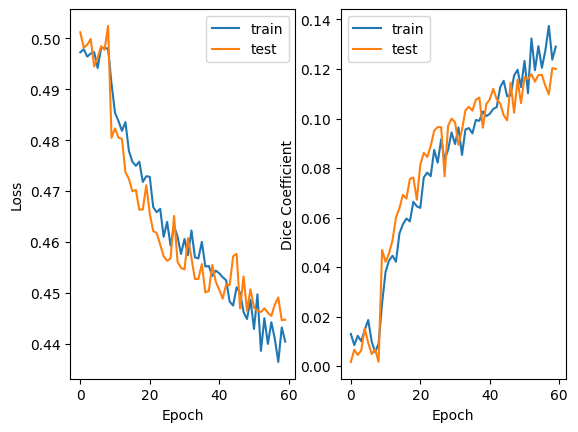

In [ ]:
# Visualization of the learning curves
# Loss
plt.subplot(1, 2, 1)
plt.plot(model_history1.history['loss'])
plt.plot(model_history1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(model_history1.history['dice_coef'])
plt.plot(model_history1.history['val_dice_coef'])
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
model1.save_weights(base_path + 'Models/Segmentation models/model1')

## Prediction Model 1

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],1)
new_model = create_model(input_shape, optimizer, loss, metrics)

In [ ]:
new_model.load_weights(base_path + 'Models/Segmentation models/model1')

In [ ]:
test_labels = np.where(np.sum(y_test, axis=(1, 2, 3)) > 0, 1, 0)
unhealty_test_indices_test = np.where(test_labels == 1)[0]

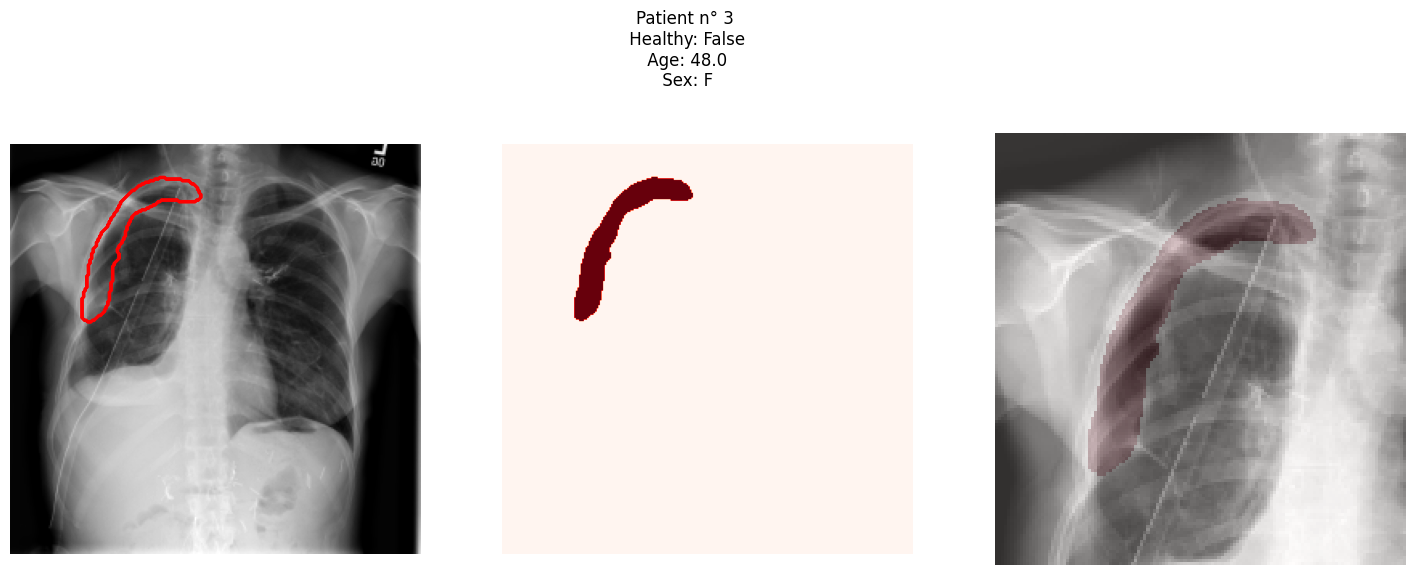

In [ ]:
# Select a patient
patient_number = unhealty_test_indices_test[1] # 1
image = X_test[patient_number,:,:,0]
mask = y_test[patient_number,:,:,0]
if np.sum(mask)==0:
    healthy = True
else:
    healthy = False

g_map = {0: 'M', 1: 'F'}
gender = g_map[gend_test[patient_number][0]]
age = age_test[patient_number][0]

fig, ax = plt.subplots(1,3, figsize=(18,7))
plt.suptitle(f'Patient n° {patient_number}\n Healthy: {healthy}\n Age: {age}\n Sex: {gender}')
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].contour(mask, colors='red')
ax[1].imshow(mask, cmap='Reds')
ax[1].axis('off')

nonzero_indices = np.nonzero(mask)
if np.sum(nonzero_indices) == 0:
    min_x, max_x = 0,len(image)-1
    min_y, max_y = 0,len(image)-1
else:
    min_x, max_x = max([min(nonzero_indices[1])-30, 0]), min([max(nonzero_indices[1])+30, image.shape[1]])
    min_y, max_y = max([min(nonzero_indices[0])-30, 0]), min([max(nonzero_indices[0])+30, image.shape[0]])

ax[2].imshow(image[min_y:max_y,min_x:max_x], cmap='gray')
ax[2].imshow(mask[min_y:max_y,min_x:max_x], cmap='Reds', alpha=0.2)
ax[2].axis('off')
plt.show()

1/1 [==============================] - 4s 4s/step


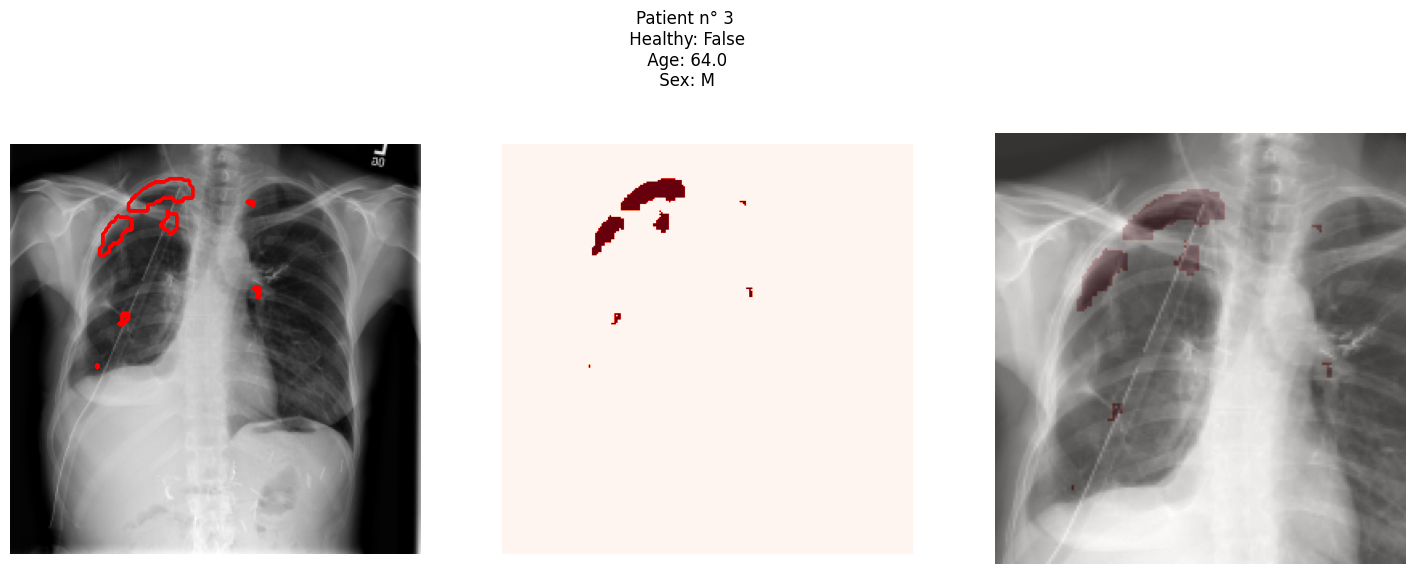

In [ ]:
pred_mask = new_model.predict(X_test[patient_number].reshape(1,256,256,1))
binary_mask_prediction = (pred_mask > 0.5).astype(np.uint8)

image = X_test[patient_number,:,:,0]
mask = binary_mask_prediction[0,:,:,0]
if np.sum(mask)==0:
    healthy = True
else:
    healthy = False

g_map = {0: 'M', 1: 'F'}
gender = g_map[gend_train[patient_number][0]]
age = age_train[patient_number][0]

fig, ax = plt.subplots(1,3, figsize=(18,7))
plt.suptitle(f'Patient n° {patient_number}\n Healthy: {healthy}\n Age: {age}\n Sex: {gender}')
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].contour(mask, colors='red')
ax[1].imshow(mask, cmap='Reds')
ax[1].axis('off')

nonzero_indices = np.nonzero(mask)
if np.sum(nonzero_indices) == 0:
    min_x, max_x = 0,len(image)-1
    min_y, max_y = 0,len(image)-1
else:
    min_x, max_x = max([min(nonzero_indices[1])-30, 0]), min([max(nonzero_indices[1])+30, image.shape[1]])
    min_y, max_y = max([min(nonzero_indices[0])-30, 0]), min([max(nonzero_indices[0])+30, image.shape[0]])

ax[2].imshow(image[min_y:max_y,min_x:max_x], cmap='gray')
ax[2].imshow(mask[min_y:max_y,min_x:max_x], cmap='Reds', alpha=0.2)
ax[2].axis('off')
plt.show()

# Model 2

## Data loading and Class Balancing

To improve model performance, we plan to balance the 'Healthy' class, which is over-represented, and the 'Unhealthy' class, which is under-represented. Instead of using data augmentation techniques that would create 'artificial' data, we have decided to use the complete dataset, as we were originally working with only half of it. We will perform downsampling of the over-represented 'Healthy' class. This way, we will train the model on a dataset with 2,500 healthy patients and approximately 2,500 unhealthy patients

In [ ]:
# file_paths = [
#     base_path + 'files/immV1.pkl',
#     base_path + 'files/segV1.pkl',
#     base_path + 'files/ageV1.pkl',
#     base_path + 'files/gendV1.pkl',
#     base_path + 'files/immV2.pkl',
#     base_path + 'files/segV2.pkl',
#     base_path + 'files/ageV2.pkl',
#     base_path + 'files/gendV2.pkl'
# ]


# for file_path in file_paths:
#     with open(file_path, 'rb') as f:
#         if 'immV1' in file_path:
#             immV1 = pickle.load(f)
#         elif 'segV1' in file_path:
#             segV1 = pickle.load(f)
#         elif 'ageV1' in file_path:
#             ageV1 = pickle.load(f)
#         elif 'gendV1' in file_path:
#             gendV1 = pickle.load(f)
#         elif 'immV2' in file_path:
#             immV2 = pickle.load(f)
#         elif 'segV2' in file_path:
#             segV2 = pickle.load(f)
#         elif 'ageV2' in file_path:
#             ageV2 = pickle.load(f)
#         elif 'gendV2' in file_path:
#             gendV2 = pickle.load(f)

Counting the number of healthy and unhealthy patients in the first half of the dataset

In [ ]:
# pixel_sums = np.sum(segV1, axis=(1, 2, 3))
# healthy_patients = np.where(pixel_sums == 0)[0]
# unhealthy_patients = np.where(pixel_sums > 0)[0]
# print(f"Number of healthy patients: {len(healthy_patients)}")
# print(f"Number of unhealthy patients: {len(unhealthy_patients)}")

Number of healthy patients: 3893
Number of unhealthy patients: 1107


Counting the number of healthy and unhealthy patients in the second half of the dataset

In [ ]:
# pixel_sums2 = np.sum(segV2, axis=(1, 2, 3))
# healthy_patients2 = np.where(pixel_sums2 == 0)[0]
# unhealthy_patients2 = np.where(pixel_sums2 > 0)[0]
# print(f"Number of healthy patients: {len(healthy_patients2)}")
# print(f"Number of unhealthy patients: {len(unhealthy_patients2)}")

Number of healthy patients: 4447
Number of unhealthy patients: 1272


Concatenate
* The first 2500 healthy patients from the first half of the dataset
* All the unhealthy patients from the first half of the dataset
* All the unhealthy patients from the second half of the dataset

In [ ]:
# immV = np.concatenate((immV1[healthy_patients,:,:,:][:2500], immV1[unhealthy_patients,:,:,:], immV2[unhealthy_patients2,:,:,:]), axis=0)
# segV = np.concatenate((segV1[healthy_patients,:,:,:][:2500], segV1[unhealthy_patients,:,:,:], segV2[unhealthy_patients2,:,:,:]), axis=0)
# ageV = np.concatenate((ageV1[healthy_patients,:][:2500], ageV1[unhealthy_patients,:], ageV2[unhealthy_patients2,:]), axis=0)
# gendV = np.concatenate((gendV1[healthy_patients,:][:2500], gendV1[unhealthy_patients,:], gendV2[unhealthy_patients2,:]), axis=0)

In [ ]:
# print(f"immV shape: \t{immV.shape}")
# print(f"segV shape: \t{segV.shape}")
# print(f"ageV shape: \t{ageV.shape}")
# print(f"gendV shape: \t{gendV.shape}")

immV shape: 	(4879, 256, 256, 1)
segV shape: 	(4879, 256, 256, 1)
ageV shape: 	(4879, 1)
gendV shape: 	(4879, 1)


In [ ]:
# with open(base_path + 'files/immV.pkl', 'wb') as f:
#     pickle.dump(immV, f)
# with open(base_path + 'files/segV.pkl', 'wb') as f:
#     pickle.dump(segV, f)
# with open(base_path + 'files/ageV.pkl', 'wb') as f:
#     pickle.dump(ageV, f)
# with open(base_path + 'files/gendV.pkl', 'wb') as f:
#     pickle.dump(gendV, f)

Load variables with pickle

In [ ]:
file_paths = [
    base_path + 'files/immV.pkl',
    base_path + 'files/segV.pkl',
    base_path + 'files/ageV.pkl',
    base_path + 'files/gendV.pkl',
]

for file_path in file_paths:
    with open(file_path, 'rb') as f:
        if 'immV' in file_path:
            immV = pickle.load(f)
        elif 'segV' in file_path:
            segV = pickle.load(f)
        elif 'ageV' in file_path:
            ageV = pickle.load(f)
        elif 'gendV' in file_path:
            gendV = pickle.load(f)

Train and Test splitting

In [ ]:
pixel_sums = np.sum(segV, axis=(1, 2, 3))
labels = np.where(pixel_sums > 0, 1, 0)
X_train, X_test, y_train, y_test, age_train, age_test, gend_train, gend_test = train_test_split(immV, segV, ageV, gendV, test_size=0.33, random_state=123654, stratify=labels)

Verify the distribution of the two classes in the training and test set


In [ ]:
train_labels = np.where(np.sum(y_train, axis=(1, 2, 3)) > 0, 1, 0)
test_labels = np.where(np.sum(y_test, axis=(1, 2, 3)) > 0, 1, 0)

print("Distribution in training set:")
print(f"Healthy: {np.sum(train_labels == 0)}, Unhealthy: {np.sum(train_labels == 1)}")
print("Distribution in test set:")
print(f"Healthy: {np.sum(test_labels == 0)}, Unhealthy: {np.sum(test_labels == 1)}")

Distribution in training set:
Healthy: 1675, Unhealthy: 1593
Distribution in test set:
Healthy: 825, Unhealthy: 786


## Model 2 Training

For the second model we will use the same architecture of the first one

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 60
batch_size = 32

optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = combined_loss
metrics = [dice_coef, IoU, pixel_accuracy]


# Callbacks
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=4,
                                                min_lr=0.0000001,
                                                verbose=1)
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],1)
# Create model
model2 = create_model(input_shape, optimizer=optimizer, loss = loss, metrics = metrics)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
# Fit model
model_history2 = model2.fit(X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs = epochs,
                            validation_data= (X_test, y_test),
                            callbacks = [callback_rp, callback_es]
                            )

Epoch 1/60
103/103 [==============================] - 83s 560ms/step - loss: 0.4978 - dice_coef: 0.0110 - IoU: 0.0055 - pixel_accuracy: 0.9895 - val_loss: 0.4982 - val_dice_coef: 0.0083 - val_IoU: 0.0042 - val_pixel_accuracy: 0.9950 - lr: 0.0010
Epoch 2/60
103/103 [==============================] - 47s 457ms/step - loss: 0.4917 - dice_coef: 0.0243 - IoU: 0.0124 - pixel_accuracy: 0.9912 - val_loss: 0.4724 - val_dice_coef: 0.0686 - val_IoU: 0.0358 - val_pixel_accuracy: 0.9848 - lr: 0.0010
Epoch 3/60
103/103 [==============================] - 48s 463ms/step - loss: 0.4629 - dice_coef: 0.0924 - IoU: 0.0490 - pixel_accuracy: 0.9870 - val_loss: 0.4459 - val_dice_coef: 0.1194 - val_IoU: 0.0643 - val_pixel_accuracy: 0.9927 - lr: 0.0010
Epoch 4/60
103/103 [==============================] - 48s 462ms/step - loss: 0.4491 - dice_coef: 0.1238 - IoU: 0.0672 - pixel_accuracy: 0.9886 - val_loss: 0.4315 - val_dice_coef: 0.1503 - val_IoU: 0.0821 - val_pixel_accuracy: 0.9913 - lr: 0.0010
Epoch 5/60
103/1

As we can see, the model overfits around epoch 30. In this case, the Early Stopping callback did not intervene. We could reduce the patience from 10 to a lower value to stop the training earlier and prevent overfitting. Additionally, we can reduce the patience for the Reduce Learning Rate on Plateau callback to make it intervene sooner and reduce noise during the last epochs of training. However, due to limited GPU resources, we couldn't afford to re-train the model.

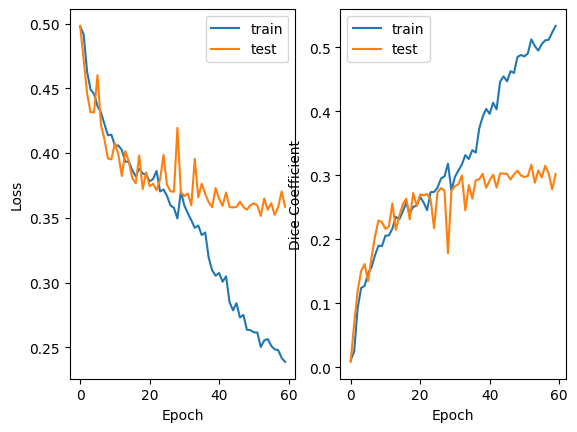

In [ ]:
# Visualization of the learning curves
# Loss
plt.subplot(1, 2, 1)
plt.plot(model_history2.history['loss'])
plt.plot(model_history2.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(model_history2.history['dice_coef'])
plt.plot(model_history2.history['val_dice_coef'])
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
model2.save_weights(base_path + 'Models/Segmentation models/model2')

## Prediction Model 2

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],1)
new_model = create_model(input_shape, optimizer, loss, metrics)

In [ ]:
new_model.load_weights(base_path + 'Models/Segmentation models/model2')

In [ ]:
test_labels = np.where(np.sum(y_test, axis=(1, 2, 3)) > 0, 1, 0)
unhealty_test_indices_test = np.where(test_labels == 1)[0]

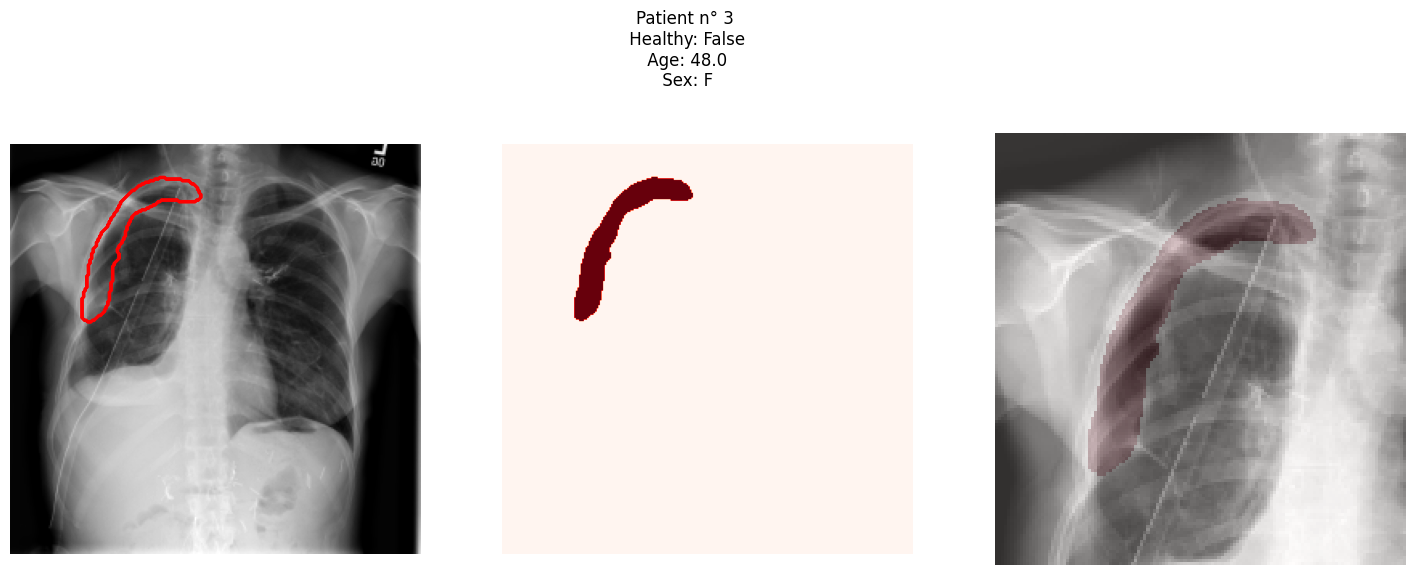

In [ ]:
# Select a patient
patient_number = unhealty_test_indices_test[1] # 8, 13, 14, 19, 21, 22

image = X_test[patient_number,:,:,0]
mask = y_test[patient_number,:,:,0]
if np.sum(mask)==0:
    healthy = True
else:
    healthy = False

g_map = {0: 'M', 1: 'F'}
gender = g_map[gend_test[patient_number][0]]
age = age_test[patient_number][0]

fig, ax = plt.subplots(1,3, figsize=(18,7))
plt.suptitle(f'Patient n° {patient_number}\n Healthy: {healthy}\n Age: {age}\n Sex: {gender}')
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].contour(mask, colors='red')
ax[1].imshow(mask, cmap='Reds')
ax[1].axis('off')

nonzero_indices = np.nonzero(mask)
if np.sum(nonzero_indices) == 0:
    min_x, max_x = 0,len(image)-1
    min_y, max_y = 0,len(image)-1
else:
    min_x, max_x = max([min(nonzero_indices[1])-30, 0]), min([max(nonzero_indices[1])+30, image.shape[1]])
    min_y, max_y = max([min(nonzero_indices[0])-30, 0]), min([max(nonzero_indices[0])+30, image.shape[0]])

ax[2].imshow(image[min_y:max_y,min_x:max_x], cmap='gray')
ax[2].imshow(mask[min_y:max_y,min_x:max_x], cmap='Reds', alpha=0.2)
ax[2].axis('off')
plt.show()

1/1 [==============================] - 0s 313ms/step


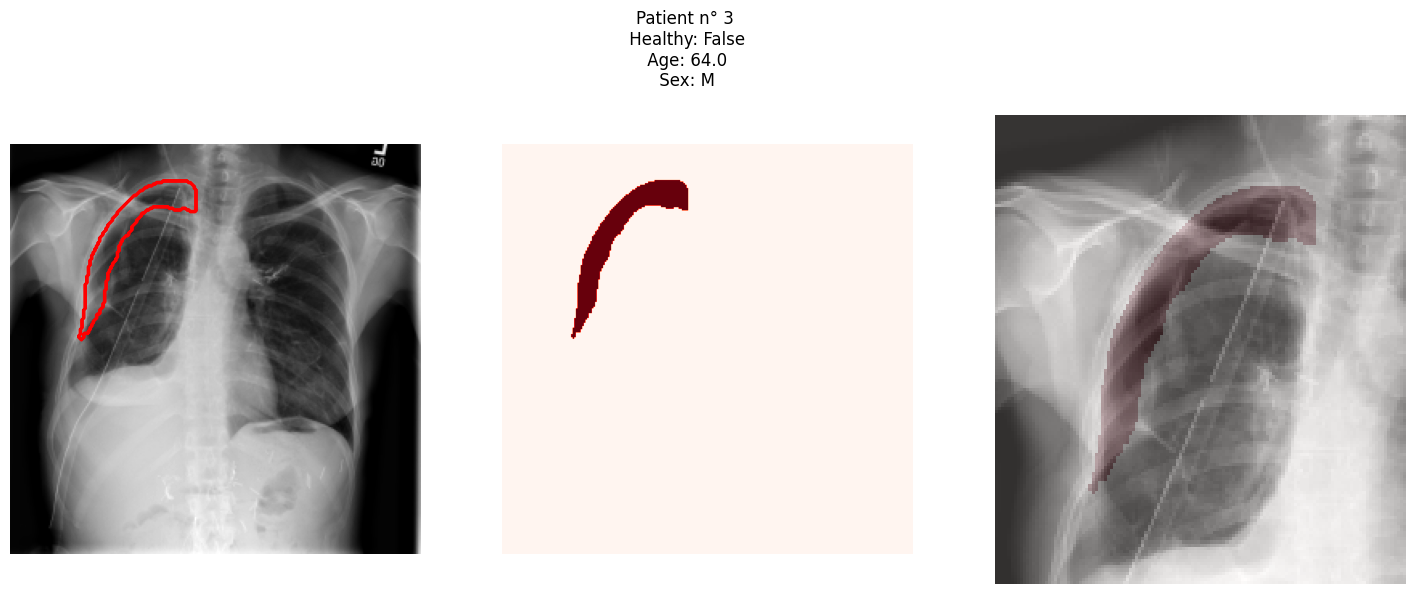

In [ ]:
pred_mask = new_model.predict(X_test[patient_number].reshape(1,256,256,1))
binary_mask_prediction = (pred_mask > 0.5).astype(np.uint8)

image = X_test[patient_number,:,:,0]
mask = binary_mask_prediction[0,:,:,0]
if np.sum(mask)==0:
    healthy = True
else:
    healthy = False

g_map = {0: 'M', 1: 'F'}
gender = g_map[gend_train[patient_number][0]]
age = age_train[patient_number][0]

fig, ax = plt.subplots(1,3, figsize=(18,7))
plt.suptitle(f'Patient n° {patient_number}\n Healthy: {healthy}\n Age: {age}\n Sex: {gender}')
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].contour(mask, colors='red')
ax[1].imshow(mask, cmap='Reds')
ax[1].axis('off')

nonzero_indices = np.nonzero(mask)
if np.sum(nonzero_indices) == 0:
    min_x, max_x = 0,len(image)-1
    min_y, max_y = 0,len(image)-1
else:
    min_x, max_x = max([min(nonzero_indices[1])-30, 0]), min([max(nonzero_indices[1])+30, image.shape[1]])
    min_y, max_y = max([min(nonzero_indices[0])-30, 0]), min([max(nonzero_indices[0])+30, image.shape[0]])

ax[2].imshow(image[min_y:max_y,min_x:max_x], cmap='gray')
ax[2].imshow(mask[min_y:max_y,min_x:max_x], cmap='Reds', alpha=0.2)
ax[2].axis('off')
plt.show()

# Nested Net

Here is an example of the Nested U-net cited above (see the paper below)

We tried training the model using the dataset with balanced classes, but due to the limited computational resources we were unable to complete the training of the model

[UNet++: A Nested U-Net Architecture for Medical Image Segmentation](https://arxiv.org/pdf/1807.10165.pdf)

## Data Loading

In [ ]:
file_paths = [
    base_path + 'files/immV.pkl',
    base_path + 'files/segV.pkl',
    base_path + 'files/ageV.pkl',
    base_path + 'files/gendV.pkl',
]

for file_path in file_paths:
    with open(file_path, 'rb') as f:
        if 'immV' in file_path:
            immV = pickle.load(f)
        elif 'segV' in file_path:
            segV = pickle.load(f)
        elif 'ageV' in file_path:
            ageV = pickle.load(f)
        elif 'gendV' in file_path:
            gendV = pickle.load(f)

Train-Test split

In [ ]:
pixel_sums = np.sum(segV, axis=(1, 2, 3))
labels = np.where(pixel_sums > 0, 1, 0)
X_train, X_test, y_train, y_test, age_train, age_test, gend_train, gend_test = train_test_split(immV, segV, ageV, gendV, test_size=0.33, random_state=123654, stratify=labels)

In [ ]:
# del immV, segV, ageV, gendV

## Model Definition

In [ ]:
dropout_rate = 0.3

from tensorflow.keras.regularizers import l2


def conv_block (input_tensor, stage, nb_filter, kernel_size=3):

    act = 'relu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

# def nested_unet(img_rows, img_cols, color_type=3, num_class=1, deep_supervision=False):
def nested_unet(input_shape, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512]
    act = 'relu'

    bn_axis = 3
    img_input = Input(shape=input_shape, name='main_input')

    conv1_1 = conv_block(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_block(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_block(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = conv_block(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_block(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_block(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = conv_block(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_block(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_block(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_block(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = conv_block(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_block(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_block(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_block(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_block(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    else:
        model = Model(img_input, [nestnet_output_4])

    return model

## Model Training

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 60
batch_size = 16

optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = combined_loss
metrics = [dice_coef]#, IoU, pixel_accuracy]


# Callbacks
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=4,
                                                min_lr=0.0000001,
                                                verbose=1)
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],1)

In [ ]:
# Getting the model
nested_unet_model = nested_unet(input_shape, num_class=1, deep_supervision=False)
nested_unet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
nested_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv11_1 (Conv2D)           (None, 256, 256, 32)         320       ['main_input[0][0]']          
                                                                                                  
 dp11_1 (Dropout)            (None, 256, 256, 32)         0         ['conv11_1[0][0]']            
                                                                                                  
 conv11_2 (Conv2D)           (None, 256, 256, 32)         9248      ['dp11_1[0][0]']              
                                                                                              

In [ ]:
nested_unet_model_history = nested_unet_model.fit(X_train,
                                                  y_train,
                                                  batch_size=batch_size,
                                                  epochs=epochs,
                                                  validation_data= (X_test, y_test),
                                                  steps_per_epoch=(len(X_train)//batch_size),
                                                  validation_steps = (len(y_test)//batch_size),
                                                  callbacks = [callback_rp, callback_es]
                                                  )

Epoch 1/60
204/204 [==============================] - 298s 1s/step - loss: 0.7703 - dice_coef: 0.0138 - val_loss: 0.6126 - val_dice_coef: 0.0171 - lr: 0.0010
Epoch 2/60
204/204 [==============================] - 273s 1s/step - loss: 0.5748 - dice_coef: 0.0289 - val_loss: 0.5367 - val_dice_coef: 0.0616 - lr: 0.0010
Epoch 3/60
204/204 [==============================] - 259s 1s/step - loss: 0.5266 - dice_coef: 0.0672 - val_loss: 0.5501 - val_dice_coef: 5.2074e-04 - lr: 0.0010
Epoch 4/60
204/204 [==============================] - 239s 1s/step - loss: 0.5042 - dice_coef: 0.0875 - val_loss: 0.5410 - val_dice_coef: 3.0967e-04 - lr: 0.0010
Epoch 5/60
204/204 [==============================] - 237s 1s/step - loss: 0.4978 - dice_coef: 0.0866 - val_loss: 0.5353 - val_dice_coef: 0.0107 - lr: 0.0010
Epoch 6/60
204/204 [==============================] - 257s 1s/step - loss: 0.4948 - dice_coef: 0.0776 - val_loss: 0.5191 - val_dice_coef: 0.0214 - lr: 0.0010
Epoch 7/60
204/204 [========================

# Conclusion and Future developments

Future developments for achieving better performance include two main areas of improvement:

Data Intervention: We plan to use the complete dataset, reduce downsampling of the over-represented class, and balance the under-represented class with data augmentation to make the model more robust. Additionally, we will avoid resizing the images from (1024,1024) to (256,256), maintaining the original resolution to preserve detail and accuracy.

Model Intervention: We intend to use the Nested U-net architecture with appropriate hyperparameter tuning, as we expect that a more complex architecture will be better suited for this segmentation task. Moreover, we could consider using pre-trained models such as VGG19 as the backbone for the encoder part, leveraging the pre-trained features to enhance model performance.